## 1. Importing Essential Libraries
We start by importing all the required Python libraries for our CycleGAN workflow.  
This includes:
- **PyTorch** (`torch`, `torch.nn`, `torch.optim`) for building and training neural networks.
- **Torchvision** for datasets and transformations.
- **PIL** for image processing.
- **itertools** for efficient looping.
- **Variable** for handling tensors with autograd support.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import itertools
from torch.autograd import Variable

## 2. Setting up the Device
We check if a GPU (CUDA) is available.  
If yes, we’ll use it for faster computation.  
If not, the code will run on CPU.

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 3. Mounting Google Drive
Since our dataset and trained models are stored in Google Drive,  
we mount the drive into our Colab environment so the code can access them directly.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## 4. Defining Image Transformations
Before feeding images into our model, we apply a set of transformations:
1. **Resize** to 256×256 pixels.
2. **CenterCrop** to keep the central region.
3. **ToTensor** to convert the image to PyTorch tensor format.
4. **Normalize** pixel values to the range [-1, 1] for stable training.


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 5. Setting Hyperparameters
We define key variables for our model:
- **`input_nc` / `output_nc`** → Number of input/output channels (RGB = 3).
- **`n_residual_blocks`** → Number of residual blocks in the generator.
- **`lr`** → Learning rate.
- **`beta1`** → Momentum term for Adam optimizer.

In [ ]:
input_nc = 3  # number of channels in the input images
output_nc = 3  # number of channels in the output images
n_residual_blocks = 9  # typical number for a CycleGAN

lr = 0.0002
beta1 = 0.5

## 6. Building the Generator Network
We define the **ResidualBlock** and **Generator** classes.  
The generator:
- Starts with an initial convolution block.
- **Downsamples** to capture features.
- Passes through multiple **Residual Blocks** for feature refinement.
- **Upsamples** back to the original resolution.
- Outputs with a **Tanh** activation for normalized pixel values.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


## 7. Building the Discriminator Network
The discriminator:
- Uses a **PatchGAN** architecture to classify local patches of the image as real or fake.
- Applies several convolution layers with increasing depth.
- Outputs a **1-channel feature map** indicating authenticity scores.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 512, 4, padding=1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True)]

        # Output layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## 9. Loading Pre-trained Models
We load pre-trained CycleGAN models (`G_A2B`, `G_B2A`, `D_A`, `D_B`) from saved `.pth` files in Google Drive.  
A helper function `load_model_ignore_mismatch` ensures we can load compatible weights even if shapes differ slightly.

In [ ]:
# Paths to the saved models
G_A2B_path = '/content/drive/MyDrive/My Research Work/Trained_Models/CycleGAN_Models/netG_A2B_epoch_24.pth'
G_B2A_path = '/content/drive/MyDrive/My Research Work/Trained_Models/CycleGAN_Models/netG_B2A_epoch_24.pth'
D_A_path = '/content/drive/MyDrive/My Research Work/Trained_Models/CycleGAN_Models/netD_A_epoch_24.pth'
D_B_path = '/content/drive/MyDrive/My Research Work/Trained_Models/CycleGAN_Models/netD_B_epoch_24.pth'

# Load the models
G_A2B = Generator(input_nc,output_nc).to(device)
G_B2A = Generator(input_nc,output_nc).to(device)
D_A = Discriminator(input_nc).to(device)
D_B = Discriminator(input_nc).to(device)

def load_model_ignore_mismatch(model, state_dict):
    model_dict = model.state_dict()
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)

# Usage example:
# Load the trained models with map_location for CPU
G_A2B.load_state_dict(torch.load(G_A2B_path, map_location=torch.device('cpu')))
G_B2A.load_state_dict(torch.load(G_B2A_path, map_location=torch.device('cpu')))

state_dict_D_A = torch.load(D_A_path, map_location=torch.device('cpu'))
state_dict_D_B = torch.load(D_B_path, map_location=torch.device('cpu'))

load_model_ignore_mismatch(D_A, state_dict_D_A)
load_model_ignore_mismatch(D_B, state_dict_D_B)

#load_model_ignore_mismatch(D_A_path, map_location=torch.device('cpu')))
#load_model_ignore_mismatch(D_B_path, map_location=torch.device('cpu')))

#D_A.load_state_dict(torch.load(D_A_path, map_location=torch.device('cpu')))
#D_B.load_state_dict(torch.load(D_B_path, map_location=torch.device('cpu')))





## 10. Additional Image Transformations for Testing
For evaluation, we define a simpler transformation:
- **ToTensor**
- **Normalization** to [-1, 1] range.


In [ ]:
# Load Data
#Sequence of transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


## 11. Loading Test Datasets
We load:
- **Benign** test images as `test_dataset_A`
- **Malignant** test images as `test_dataset_B`  
and prepare them with DataLoaders for batch-wise processing.

In [ ]:
# Load test datasets
test_dataset_A = datasets.ImageFolder(root='/content/drive/MyDrive/My Research Work/Dataset/test/benign', transform=transform)  # Load benign test dataset
test_dataset_B = datasets.ImageFolder(root='/content/drive/MyDrive/My Research Work/Dataset/test/malignant', transform=transform)  # Load malignant test dataset

# Data loaders
test_loader_A = DataLoader(test_dataset_A, batch_size=1, shuffle=False)
test_loader_B = DataLoader(test_dataset_B, batch_size=1, shuffle=False)


## 12. Loading Pre-trained FCN Segmentation Model
We bring in **FCN-ResNet50** (Fully Convolutional Network) for semantic segmentation.  
This will be used to compare the structural content of real vs. generated images.


In [ ]:
import torch
import torchvision.models.segmentation as segmentation

# Load pre-trained FCN model
fcn_model = segmentation.fcn_resnet50(pretrained=True).eval().to(device)


## 13. Defining Pixel Accuracy Metrics
We define functions to calculate:
- **Per Pixel Accuracy (PPA)** → Fraction of correctly matched pixels.
- **Per Class Accuracy (PCA)** → Accuracy per segmentation class, then averaged.


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

def calculate_per_pixel_accuracy(seg_map_real, seg_map_fake):
    """
    Calculate Per Pixel Accuracy (PPA).

    Args:
    - seg_map_real (np.array): The real segmentation map.
    - seg_map_fake (np.array): The generated segmentation map.

    Returns:
    - ppa (float): Per Pixel Accuracy.
    """
    return accuracy_score(seg_map_real.flatten(), seg_map_fake.flatten())

def calculate_per_class_accuracy(seg_map_real, seg_map_fake):
    """
    Calculate Per Class Accuracy (PCA).

    Args:
    - seg_map_real (np.array): The real segmentation map.
    - seg_map_fake (np.array): The generated segmentation map.

    Returns:
    - pca (float): Per Class Accuracy.
    """
    labels = np.unique(seg_map_real)
    accuracies = []
    for label in labels:
        mask = seg_map_real == label
        accuracies.append(accuracy_score(seg_map_real[mask], seg_map_fake[mask]))
    return np.mean(accuracies)

# Example usage for a batch of images
ppa_scores = []
pca_scores = []

## 14. Defining IoU (Intersection over Union) Metric
We:
- Create a helper to get segmentation maps from the FCN model.
- Define `calculate_iou` to measure overlap between real and generated segmentation maps.

In [ ]:
import torch
import torchvision.models.segmentation as segmentation
from sklearn.metrics import jaccard_score
import numpy as np

# Load pre-trained FCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fcn_model = segmentation.fcn_resnet50(pretrained=True).eval().to(device)

def get_segmentation_map(image, model):
    if len(image.shape) == 4:
        # Image is already in the correct shape
        input_tensor = image
    elif len(image.shape) == 3:
        # Add batch dimension
        input_tensor = image.unsqueeze(0)
    else:
        raise ValueError(f"Unexpected input shape: {image.shape}")

    with torch.no_grad():
        output = model(input_tensor)['out']
        seg_map = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
    return seg_map

def calculate_iou(seg_map_real, seg_map_fake):
    seg_map_real_flat = seg_map_real.flatten()
    seg_map_fake_flat = seg_map_fake.flatten()
    return jaccard_score(seg_map_real_flat, seg_map_fake_flat, average='macro')

# Example usage for a batch of images
iou_scores = []

## 15. Creating Directories for Saving Images
We make folders in Google Drive to store:
- **Generated** images (benign → malignant, malignant → benign).
- **Real** images from both categories.

In [ ]:
import os
from torchvision.utils import save_image
# Directories for saving generated test images
os.makedirs('/content/drive/MyDrive/test_generated_by_real_cyclegan/benign_to_malignant', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_generated_by_real_cyclegan/malignant_to_benign', exist_ok=True)
# Directories for saving real test images
os.makedirs('/content/drive/MyDrive/test_real_by_real_cyclegan/real_benign', exist_ok=True)
os.makedirs('/content/drive/MyDrive/test_real_by_real_cyclegan/real_malignant', exist_ok=True)

## 16. Generating Images & Calculating Metrics
This is the **main evaluation loop**:
1. Load images from both domains.
2. Generate fake images using the trained generators.
3. Save both real and generated images.
4. Calculate:
   - **SSIM** (Structural Similarity)
   - **PSNR** (Peak Signal-to-Noise Ratio)
   - **MSE** (Mean Squared Error)
   - **IoU**
   - **PPA**
   - **PCA**

In [ ]:
import os
import torch
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Function to compute MSE
def mse(img1, img2):
    return F.mse_loss(img1, img2).item()

# Lists to store metrics
ssim_values = []
psnr_values = []
mse_values = []

with torch.no_grad():
    for i, (data_A, data_B) in enumerate(zip(test_loader_A, test_loader_B)):
        print(f'Processing image {i+1}')
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # Generate fake images
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)

        save_image(fake_B, f'/content/drive/MyDrive/test_generated_by_real_cyclegan/benign_to_malignant/{i}.png')
        save_image(fake_A, f'/content/drive/MyDrive/test_generated_by_real_cyclegan/malignant_to_benign/{i}.png')
        save_image(real_A, f'/content/drive/MyDrive/test_real_by_real_cyclegan/real_benign/{i}.png')
        save_image(real_B, f'/content/drive/MyDrive/test_real_by_real_cyclegan/real_malignant/{i}.png')

        # Check shapes before transposing
        print(f'Shape of real_A: {real_A.shape}')
        print(f'Shape of real_B: {real_B.shape}')
        print(f'Shape of fake_A: {fake_A.shape}')
        print(f'Shape of fake_B: {fake_B.shape}')

        # Remove batch dimension and convert images to numpy arrays
        real_A_np = real_A[0].cpu().numpy().transpose(1, 2, 0)
        real_B_np = real_B[0].cpu().numpy().transpose(1, 2, 0)
        fake_A_np = fake_A[0].cpu().numpy().transpose(1, 2, 0)
        fake_B_np = fake_B[0].cpu().numpy().transpose(1, 2, 0)

        # Compute metrics for benign to malignant
        ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
        psnr_value = psnr(real_B_np, fake_B_np)
        mse_value = mse(real_B, fake_B)

        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)

        # Compute metrics for malignant to benign
        ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)
        psnr_value = psnr(real_A_np, fake_A_np)
        mse_value = mse(real_A, fake_A)

        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)

        # Get segmentation maps
        seg_map_real_B = get_segmentation_map(real_B, fcn_model)
        seg_map_fake_B = get_segmentation_map(fake_B, fcn_model)
        seg_map_real_A = get_segmentation_map(real_A, fcn_model)
        seg_map_fake_A = get_segmentation_map(fake_A, fcn_model)

        # Calculate IoU
        iou_B = calculate_iou(seg_map_real_B, seg_map_fake_B)
        iou_A = calculate_iou(seg_map_real_A, seg_map_fake_A)

        iou_scores.append((iou_A + iou_B) / 2)  # Average IoU for both directions

         # Calculate metrics for benign to malignant
        ppa_B = calculate_per_pixel_accuracy(seg_map_real_B, seg_map_fake_B)
        pca_B = calculate_per_class_accuracy(seg_map_real_B, seg_map_fake_B)

        # Calculate metrics for malignant to benign
        ppa_A = calculate_per_pixel_accuracy(seg_map_real_A, seg_map_fake_A)
        pca_A = calculate_per_class_accuracy(seg_map_real_A, seg_map_fake_A)

        # Average metrics for both directions
        ppa_scores.append((ppa_A + ppa_B) / 2)
        pca_scores.append((pca_A + pca_B) / 2)

Processing image 1
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 2
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 3
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 4
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 5
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 6
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 7
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 8
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 9
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 10
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 11
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 12
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 13
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 14
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 15
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 16
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 17
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 18
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 19
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 20
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 21
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 22
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 23
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 24
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 25
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 26
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 27
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 28
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 29
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 30
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 31
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 32
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 33
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 34
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 35
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 36
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 37
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 38
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 39
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 40
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 41
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 42
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 43
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 44
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 45
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 46
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 47
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 48
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 49
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 50
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 51
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 52
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 53
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 54
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 55
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 56
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 57
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 58
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 59
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 60
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 61
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 62
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 63
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 64
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 65
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 66
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 67
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 68
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 69
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 70
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 71
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 72
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 73
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 74
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 75
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 76
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 77
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 78
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 79
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 80
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 81
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 82
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 83
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 84
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 85
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 86
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 87
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 88
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 89
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 90
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 91
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 92
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 93
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 94
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 95
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 96
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 97
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 98
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 99
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 100
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 101
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 102
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 103
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 104
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 105
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 106
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 107
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 108
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 109
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 110
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 111
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 112
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 113
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 114
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 115
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 116
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 117
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 118
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 119
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 120
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 121
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 122
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 123
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 124
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 125
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 126
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 127
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 128
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 129
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 130
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 131
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 132
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 133
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 134
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 135
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 136
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 137
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 138
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 139
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 140
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 141
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 142
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 143
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 144
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 145
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 146
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 147
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 148
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 149
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


Processing image 150
Shape of real_A: torch.Size([1, 3, 460, 700])
Shape of real_B: torch.Size([1, 3, 460, 700])
Shape of fake_A: torch.Size([1, 3, 460, 700])
Shape of fake_B: torch.Size([1, 3, 460, 700])


<ipython-input-23-850992a99745>:50: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_B_np, fake_B_np, multichannel=True)
<ipython-input-23-850992a99745>:59: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(real_A_np, fake_A_np, multichannel=True)


## 17. Printing Average Evaluation Scores
We compute and display:
- **Average IoU**
- **Average PPA**
- **Average PCA**

In [ ]:
# Average IoU for the dataset
average_iou = np.mean(iou_scores)
print(f'Average IoU: {average_iou:.4f}')

# Average metrics for the dataset
average_ppa = np.mean(ppa_scores)
average_pca = np.mean(pca_scores)
print(f'Average Per Pixel Accuracy: {average_ppa:.4f}')
print(f'Average Per Class Accuracy: {average_pca:.4f}')

Average IoU: 0.3091
Average Per Pixel Accuracy: 0.9426
Average Per Class Accuracy: 0.4653


## 18. Plotting Evaluation Metrics
We visualize:
- SSIM scores
- PSNR values
- MSE values  
to see variation across test samples.

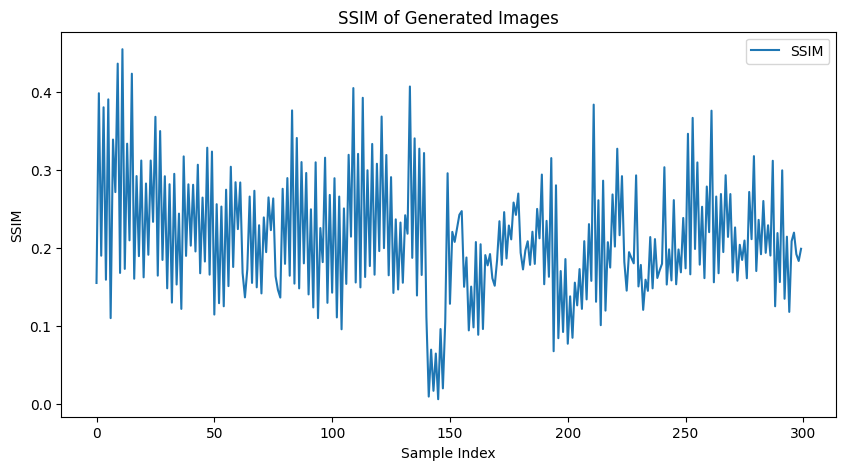

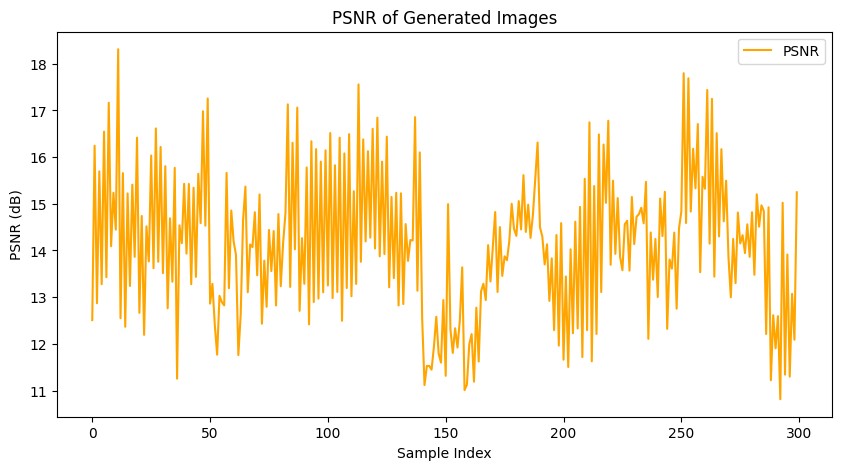

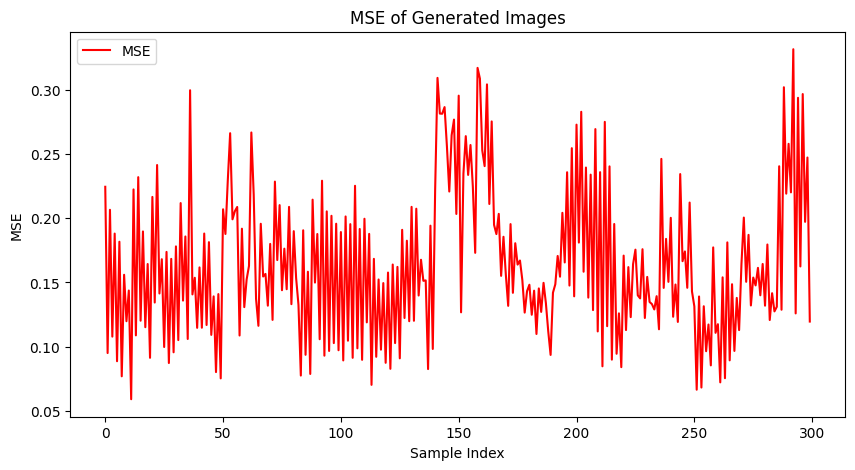

In [ ]:
# Plot SSIM
plt.figure(figsize=(10, 5))
plt.plot(ssim_values, label='SSIM')
plt.xlabel('Sample Index')
plt.ylabel('SSIM')
plt.title('SSIM of Generated Images')
plt.legend()
plt.show()

# Plot PSNR
plt.figure(figsize=(10, 5))
plt.plot(psnr_values, label='PSNR', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('PSNR (dB)')
plt.title('PSNR of Generated Images')
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(10, 5))
plt.plot(mse_values, label='MSE', color='red')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title('MSE of Generated Images')
plt.legend()
plt.show()

## 19. Function to Plot Real vs. Generated Images
We define `plot_single_real_and_fake_image` to visually compare a real image and its generated counterpart side-by-side.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_single_real_and_fake_image(real_image, fake_image):
    """
    Plots a comparison of a single real and a single generated (fake) image.

    Parameters:
    - real_image: a single Tensor image (C, H, W).
    - fake_image: a single Tensor image (C, H, W).
    """
    plt.figure(figsize=(8, 4))

    # Display the real image
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Image")
    real_image = vutils.make_grid(real_image, normalize=True).permute(1, 2, 0).cpu().numpy()
    plt.imshow(real_image)

    # Display the fake image
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Generated Image")
    fake_image = vutils.make_grid(fake_image, normalize=True).permute(1, 2, 0).cpu().numpy()
    plt.imshow(fake_image)

    plt.show()

## 20. Displaying a Few Example Results
We loop over a few samples and plot real-vs-generated images for both:
- Benign → Malignant
- Malignant → Benign

Image :  0


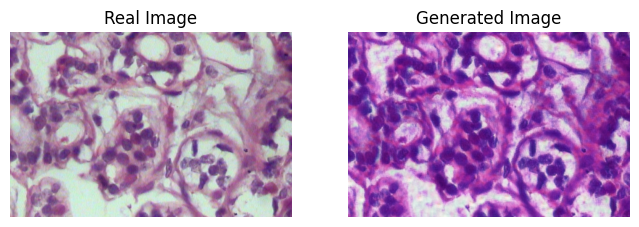

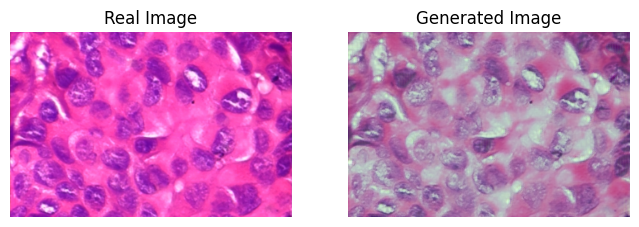

Image :  1


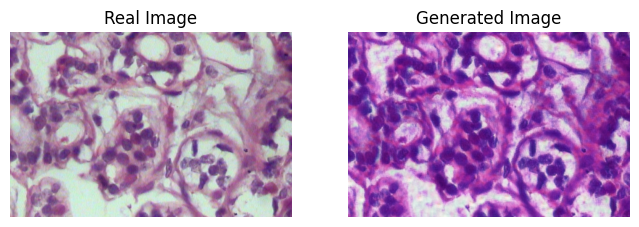

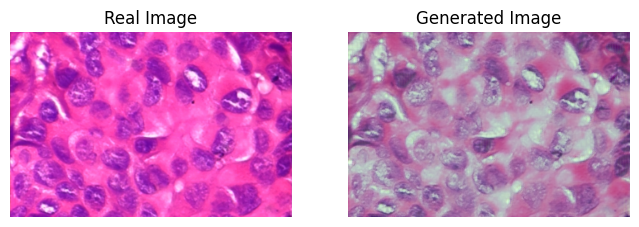

Image :  2


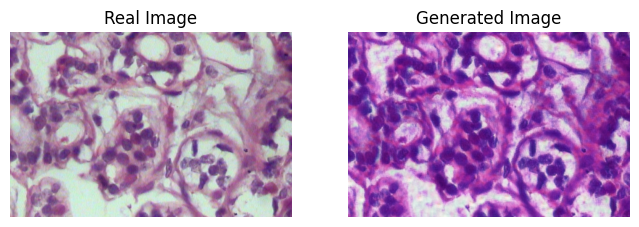

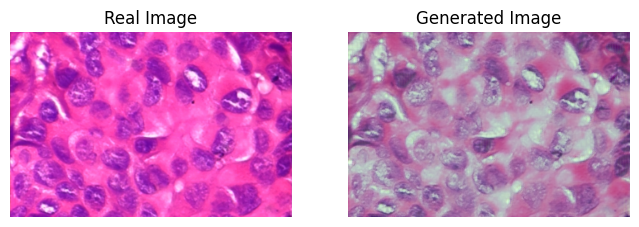

In [ ]:
for i in range(3):
    print("Image : ", i)
    plot_single_real_and_fake_image(real_A[0], fake_B[0])  # Pass the first image of the batch
    plot_single_real_and_fake_image(real_B[0], fake_A[0])